## imports

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import os
from os.path import join, exists
import sys
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.autograd import Variable as V
from torch.nn import functional as F
from torchsummary import summary
import torch.nn  as nn
from PIL import Image
from IPython.core.debugger import set_trace
import nethook as nethook
import scipy.io as sio
from tqdm import tqdm
import time
import importlib
import cornet
import rsatools as rsa
import nnutils as utils

importlib.reload(rsa)
importlib.reload(utils)


<module 'nnutils' from '/home/jacobpri/git/RotspaceIT/notebooks/nnutils.py'>

## hyperparameters

In [66]:
arch = 'alexnet'
trained_on = 'object'
imageset = 'imagefiles-fullset'
img_dim = 224
batch_size = 80
save_as = '.npy'
save_layer_rdvs = True
rdv_dist = 'correlation'
overwrite = False
verbose = True

## directory management

In [67]:
home_dir = '/home/jacobpri/git/RotspaceIT/'

# target directory for saving activations
activation_savedir = join(home_dir,'data','d02_modeling','activations')

# target directory for saving layer-wise RDVs
rdv_savedir = join(home_dir,'data','d02_modeling','rdvs')

# folder of trained model weights
weight_dir = join(home_dir,'data','d02_modeling','weights')

# folder of image sets
imageset_dir = join(home_dir,'imagesets')

load_arch = arch + '-' + trained_on

dirs = os.listdir(imageset_dir)

found = False
for d in dirs:
    d_ = os.listdir(join(imageset_dir,d))
    if (imageset in d_):
        imageset_dir = join(imageset_dir, d, imageset)
        activation_savedir = join(activation_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        rdv_savedir = join(rdv_savedir, load_arch, d, imageset, 'dim' + str(img_dim))
        found = True
        break

if found is False:
    raise ValueError('image set not found')   

# create savedir if it doesn't yet exist 
os.makedirs(activation_savedir, exist_ok=True)
os.makedirs(rdv_savedir, exist_ok=True)

print("imageset dir %s\n" % imageset_dir)
print("weight dir %s\n" % weight_dir)
print("activation save destination: %s\n" % activation_savedir)
print("rdv save destination: %s\n" % rdv_savedir)

assert(exists(activation_savedir))
assert(exists(imageset_dir))
assert(exists(weight_dir))
assert(save_as == '.npy' or save_as == '.mat')

imageset dir /home/jacobpri/git/RotspaceIT/imagesets/localizer/imagefiles-fullset

weight dir /home/jacobpri/git/RotspaceIT/data/d02_modeling/weights

activation save destination: /home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224

rdv save destination: /home/jacobpri/git/RotspaceIT/data/d02_modeling/rdvs/alexnet-object/localizer/imagefiles-fullset/dim224



## load architecture

In [68]:
if load_arch == 'alexnet':
    model = models.alexnet(pretrained = True)

elif load_arch == 'alexnet-random':
    model = models.alexnet()
    
elif load_arch == 'alexnet-object':
    checkpoint = torch.load(os.path.join(weight_dir,'alexnet_imagenet_final.pth.tar'),map_location='cpu')
    checkpoint['state_dict'] = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model = models.alexnet(num_classes=1000)
    model.load_state_dict(checkpoint['state_dict'])

elif load_arch == 'alexnet-face':
    #model = models.__dict__['alexnet'](num_classes=9131)
    checkpoint = torch.load(os.path.join(weight_dir,'alexnet_faces_final.pth.tar'),map_location='cpu')
    #print(checkpoint['state_dict'].keys())
    checkpoint['state_dict'] = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model = models.alexnet(num_classes=3372)
    model.load_state_dict(checkpoint['state_dict'])

elif load_arch == 'alexnet-scene':
    checkpoint = torch.load(os.path.join(weight_dir,'alexnet_places_final.pth.tar'),map_location='cpu')
    checkpoint['state_dict'] = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model = models.alexnet(num_classes=365)
    model.load_state_dict(checkpoint['state_dict'])

elif load_arch == 'resnet18-object':
    model = models.resnet18(pretrained = True)

elif load_arch == 'vgg16-object':
    model = models.vgg16(pretrained = True)

elif load_arch == 'cornet-z-object':
    model = cornet.CORnet_Z()
    checkpoint = torch.load(os.path.join(weight_dir,'cornet_z-5c427c9c.pth'),map_location='cpu')
    checkpoint['state_dict'] = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(checkpoint['state_dict']) 

elif load_arch == 'cornet-s-object':
    model = cornet.CORnet_S()
    checkpoint = torch.load(os.path.join(weight_dir,'cornet_s-1d3f7974.pth'),map_location='cpu')
    checkpoint['state_dict'] = {str.replace(k,'module.',''): v for k,v in checkpoint['state_dict'].items()}
    model.load_state_dict(checkpoint['state_dict']) 

else:
    raise ValueError('model name not recognized')

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## convert all relus to "inplace=False" so previous layer values are preserved

In [69]:
utils.convert_relu(model)

print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4

## get string names/indices of each layer 

In [70]:
lay_names_torch, lay_names_user, lay_names_user_fmt = utils.get_layer_names(model)

['1_conv1', '2_relu1', '3_maxpool1', '4_conv2', '5_relu2', '6_maxpool2', '7_conv3', '8_relu3', '9_conv4', '10_relu4', '11_conv5', '12_relu5', '13_maxpool5', '14_avgpool5', '15_drop5', '16_fc6', '17_relu6', '18_drop6', '19_fc7', '20_relu7', '21_fc8']


## send model to the gpu, if available

In [71]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model = model.to(device)

In [73]:
!nvidia-smi

Wed Mar 18 00:59:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 430.50       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   29C    P2    67W / 250W |   1231MiB / 12212MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## estimate size in memory of passing one image through

In [74]:
summary(model,(3,img_dim,img_dim))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

## convert model to instrumented model

In [75]:
# you only want to do this conversion ONCE
if not isinstance(model, nethook.InstrumentedModel):

    # convert to instrumented model
    model = nethook.InstrumentedModel(model)
else:
    print('warning: network is already InstrumentedModel')

## choose layers to retain (for extracting activations)

In [76]:
all_types = ['conv','relu','pool','norm','drop','fc','downsample','identity','flatten']
includes = all_types #['conv','fc','relu']#all_types#['relu','conv','fc']#all_types#['conv','fc','relu']#all_types#['conv','relu','fc','relu','norm','drop','pool','flatten']#all_types#['conv','fc']

layers_to_retain = []
layers_to_retain_fmt = []

for i in range(len(lay_names_user_fmt)):
    if any(s in lay_names_user_fmt[i] for s in includes):
        layers_to_retain.append(lay_names_torch[i])
        layers_to_retain_fmt.append(lay_names_user_fmt[i])

print(layers_to_retain,'\n')
print(layers_to_retain_fmt,'\n')
print('%d layers chosen' % len(layers_to_retain))

['features.0', 'features.1', 'features.2', 'features.3', 'features.4', 'features.5', 'features.6', 'features.7', 'features.8', 'features.9', 'features.10', 'features.11', 'features.12', 'avgpool', 'classifier.0', 'classifier.1', 'classifier.2', 'classifier.3', 'classifier.4', 'classifier.5', 'classifier.6'] 

['1_conv1', '2_relu1', '3_maxpool1', '4_conv2', '5_relu2', '6_maxpool2', '7_conv3', '8_relu3', '9_conv4', '10_relu4', '11_conv5', '12_relu5', '13_maxpool5', '14_avgpool5', '15_drop5', '16_fc6', '17_relu6', '18_drop6', '19_fc7', '20_relu7', '21_fc8'] 

21 layers chosen


## retain chosen layers of instrumented model

In [77]:
for layer_name in layers_to_retain: model.retain_layer(layer_name) 

## load image set, create dataset object

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /home/jacobpri/git/RotspaceIT/imagesets/localizer/imagefiles-fullset
(<PIL.Image.Image image mode=RGB size=322x393 at 0x7F91AA6F1940>, 0)


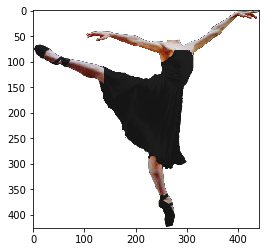

In [78]:
dataset = datasets.ImageFolder(root = imageset_dir)

# print some info -> verify correct # imgs, etc
print(dataset)

# PIL image format, tuple where first element is image itself and second element is class ID
print(dataset[0])

# display image
plt.imshow(dataset[12][0])

## create transform object

In [79]:
# normalize images using parameters from the training image set
data_transform = transforms.Compose([       
 transforms.Resize(img_dim),                   
 transforms.CenterCrop((img_dim,img_dim)),         
 transforms.ToTensor(),                    
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])

# reload the dataset, this time applying the transform
dataset =  datasets.ImageFolder(root = imageset_dir, transform = data_transform)

## check result of transforms

In [80]:
draw_figs = False
if draw_figs:
    plt.figure(figsize=(20,20))
    c = 1
    for i in range(0,len(dataset),(len(dataset)//25)-2):
        plt.subplot(5,5,c)
        plt.imshow(dataset[i][0][0].numpy(),cmap='gray')
        c+=1
        if c > 25:
            break

## create dataloader

In [81]:
# data loader object is required for passing images through the network - choose batch size and num workers here
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    num_workers=0,
    shuffle=False
)

## get activations

In [82]:
absolute_act_filepaths = []
total_MB_saved = 0

# not training mode
model.eval()

# no gradient saving 
with torch.no_grad():

    # dictionary comprehension
    features = {layer: None for layer in layers_to_retain}

    with tqdm(total=100,desc='Computing network activations') as pbar:

        # iterate through batches
        for batch_no, (imgs,labels) in enumerate(data_loader):
            
            batch_str = 'batch-' + str(batch_no)
            
            time.sleep(0.1)
            
            # nethook is saving features in a dictionary
            if torch.cuda.is_available():
                out = model(imgs.to(device))
            else:
                out = model(imgs)
            
            # counter for layer names
            idx = 0
            
            # accumulate activations by looping through layer names
            for layer_name in layers_to_retain:
                
                # get name
                layer_str = layers_to_retain_fmt[idx]
                
                save_str = layer_str + '_batchsize-' + str(batch_size) + '_' + batch_str + save_as
                save_fn = join(activation_savedir, save_str)
                
                absolute_act_filepaths.append(save_fn)
                    
                # need to reshape for concatenation
                X = model.retained_layer(layer_name)

                # move to CPU and detatch from computational grid
                X = X.cpu().detach().numpy() 
    
                # compute size in memory:
                X_mem = np.divide(float(X.size * X.itemsize),1000000)
            
                # save batch
                if verbose is True:
                    print("\tfile to save: %s (size in memory: %0.3f MB)" % (save_str, X_mem))
                
                if exists(save_fn) and overwrite is False:
                    print('skipping, file %s already exists' % save_str)
                else:
                    
                    total_MB_saved += X_mem
                    
                    if save_as == '.npy':
                        np.save(save_fn, X)
                    elif save_as == '.mat':
                        sio.savemat(save_fn, {'X': X})
                    else:
                        raise ValueError('no file type specified')
                        
                # concatenate if necessary
                if save_layer_rdvs is True:

                    # chunk on to the dictionary
                    if features[layer_name] is None:
                        features[layer_name] = X
                    else:                
                        features[layer_name] = np.concatenate((features[layer_name], X), axis = 0)

                idx += 1 

            pbar.update(100/len(data_loader))

path_save_str = 'absolute_act_filepaths_batchsize-' + str(batch_size) + save_as
path_save_fn = join(activation_savedir, path_save_str)
print(path_save_fn)

if save_as == '.npy':
    np.save(path_save_fn, absolute_act_filepaths)
elif save_as == '.mat':
    sio.savemat(path_save_fn, {'absolute_act_filepaths': absolute_act_filepaths})
else:
    raise ValueError('no file type specified')
    
print('total memory saved: %0.3f MB' % total_MB_saved)

Computing network activations:   0%|          | 0/100 [00:00<?, ?it/s]

	file to save: 1_conv1_batchsize-80_batch-0.npy (size in memory: 61.952 MB)
	file to save: 2_relu1_batchsize-80_batch-0.npy (size in memory: 61.952 MB)
	file to save: 3_maxpool1_batchsize-80_batch-0.npy (size in memory: 14.930 MB)
	file to save: 4_conv2_batchsize-80_batch-0.npy (size in memory: 44.790 MB)
	file to save: 5_relu2_batchsize-80_batch-0.npy (size in memory: 44.790 MB)
	file to save: 6_maxpool2_batchsize-80_batch-0.npy (size in memory: 10.383 MB)
	file to save: 7_conv3_batchsize-80_batch-0.npy (size in memory: 20.767 MB)
	file to save: 8_relu3_batchsize-80_batch-0.npy (size in memory: 20.767 MB)
	file to save: 9_conv4_batchsize-80_batch-0.npy (size in memory: 13.844 MB)
	file to save: 10_relu4_batchsize-80_batch-0.npy (size in memory: 13.844 MB)


Computing network activations:  20%|██        | 20.0/100 [00:03<00:13,  5.85it/s]

	file to save: 11_conv5_batchsize-80_batch-0.npy (size in memory: 13.844 MB)
	file to save: 12_relu5_batchsize-80_batch-0.npy (size in memory: 13.844 MB)
	file to save: 13_maxpool5_batchsize-80_batch-0.npy (size in memory: 2.949 MB)
	file to save: 14_avgpool5_batchsize-80_batch-0.npy (size in memory: 2.949 MB)
	file to save: 15_drop5_batchsize-80_batch-0.npy (size in memory: 2.949 MB)
	file to save: 16_fc6_batchsize-80_batch-0.npy (size in memory: 1.311 MB)
	file to save: 17_relu6_batchsize-80_batch-0.npy (size in memory: 1.311 MB)
	file to save: 18_drop6_batchsize-80_batch-0.npy (size in memory: 1.311 MB)
	file to save: 19_fc7_batchsize-80_batch-0.npy (size in memory: 1.311 MB)
	file to save: 20_relu7_batchsize-80_batch-0.npy (size in memory: 1.311 MB)
	file to save: 21_fc8_batchsize-80_batch-0.npy (size in memory: 0.320 MB)
	file to save: 1_conv1_batchsize-80_batch-1.npy (size in memory: 61.952 MB)
	file to save: 2_relu1_batchsize-80_batch-1.npy (size in memory: 61.952 MB)
	file to s

Computing network activations:  40%|████      | 40.0/100 [00:11<00:14,  4.21it/s]

	file to save: 17_relu6_batchsize-80_batch-1.npy (size in memory: 1.311 MB)
	file to save: 18_drop6_batchsize-80_batch-1.npy (size in memory: 1.311 MB)
	file to save: 19_fc7_batchsize-80_batch-1.npy (size in memory: 1.311 MB)
	file to save: 20_relu7_batchsize-80_batch-1.npy (size in memory: 1.311 MB)
	file to save: 21_fc8_batchsize-80_batch-1.npy (size in memory: 0.320 MB)
	file to save: 1_conv1_batchsize-80_batch-2.npy (size in memory: 61.952 MB)
	file to save: 2_relu1_batchsize-80_batch-2.npy (size in memory: 61.952 MB)
	file to save: 3_maxpool1_batchsize-80_batch-2.npy (size in memory: 14.930 MB)
	file to save: 4_conv2_batchsize-80_batch-2.npy (size in memory: 44.790 MB)
	file to save: 5_relu2_batchsize-80_batch-2.npy (size in memory: 44.790 MB)
	file to save: 6_maxpool2_batchsize-80_batch-2.npy (size in memory: 10.383 MB)
	file to save: 7_conv3_batchsize-80_batch-2.npy (size in memory: 20.767 MB)
	file to save: 8_relu3_batchsize-80_batch-2.npy (size in memory: 20.767 MB)
	file to s

Computing network activations:  60%|██████    | 60.0/100 [00:17<00:10,  3.82it/s]

	file to save: 12_relu5_batchsize-80_batch-2.npy (size in memory: 13.844 MB)
	file to save: 13_maxpool5_batchsize-80_batch-2.npy (size in memory: 2.949 MB)
	file to save: 14_avgpool5_batchsize-80_batch-2.npy (size in memory: 2.949 MB)
	file to save: 15_drop5_batchsize-80_batch-2.npy (size in memory: 2.949 MB)
	file to save: 16_fc6_batchsize-80_batch-2.npy (size in memory: 1.311 MB)
	file to save: 17_relu6_batchsize-80_batch-2.npy (size in memory: 1.311 MB)
	file to save: 18_drop6_batchsize-80_batch-2.npy (size in memory: 1.311 MB)
	file to save: 19_fc7_batchsize-80_batch-2.npy (size in memory: 1.311 MB)
	file to save: 20_relu7_batchsize-80_batch-2.npy (size in memory: 1.311 MB)
	file to save: 21_fc8_batchsize-80_batch-2.npy (size in memory: 0.320 MB)
	file to save: 1_conv1_batchsize-80_batch-3.npy (size in memory: 61.952 MB)
	file to save: 2_relu1_batchsize-80_batch-3.npy (size in memory: 61.952 MB)
	file to save: 3_maxpool1_batchsize-80_batch-3.npy (size in memory: 14.930 MB)
	file to

Computing network activations:  80%|████████  | 80.0/100 [00:25<00:05,  3.33it/s]

	file to save: 12_relu5_batchsize-80_batch-3.npy (size in memory: 13.844 MB)
	file to save: 13_maxpool5_batchsize-80_batch-3.npy (size in memory: 2.949 MB)
	file to save: 14_avgpool5_batchsize-80_batch-3.npy (size in memory: 2.949 MB)
	file to save: 15_drop5_batchsize-80_batch-3.npy (size in memory: 2.949 MB)
	file to save: 16_fc6_batchsize-80_batch-3.npy (size in memory: 1.311 MB)
	file to save: 17_relu6_batchsize-80_batch-3.npy (size in memory: 1.311 MB)
	file to save: 18_drop6_batchsize-80_batch-3.npy (size in memory: 1.311 MB)
	file to save: 19_fc7_batchsize-80_batch-3.npy (size in memory: 1.311 MB)
	file to save: 20_relu7_batchsize-80_batch-3.npy (size in memory: 1.311 MB)
	file to save: 21_fc8_batchsize-80_batch-3.npy (size in memory: 0.320 MB)
	file to save: 1_conv1_batchsize-80_batch-4.npy (size in memory: 61.952 MB)
	file to save: 2_relu1_batchsize-80_batch-4.npy (size in memory: 61.952 MB)
	file to save: 3_maxpool1_batchsize-80_batch-4.npy (size in memory: 14.930 MB)
	file to

Computing network activations: 100%|██████████| 100.0/100 [00:33<00:00,  3.02it/s]

	file to save: 13_maxpool5_batchsize-80_batch-4.npy (size in memory: 2.949 MB)
	file to save: 14_avgpool5_batchsize-80_batch-4.npy (size in memory: 2.949 MB)
	file to save: 15_drop5_batchsize-80_batch-4.npy (size in memory: 2.949 MB)
	file to save: 16_fc6_batchsize-80_batch-4.npy (size in memory: 1.311 MB)
	file to save: 17_relu6_batchsize-80_batch-4.npy (size in memory: 1.311 MB)
	file to save: 18_drop6_batchsize-80_batch-4.npy (size in memory: 1.311 MB)
	file to save: 19_fc7_batchsize-80_batch-4.npy (size in memory: 1.311 MB)
	file to save: 20_relu7_batchsize-80_batch-4.npy (size in memory: 1.311 MB)
	file to save: 21_fc8_batchsize-80_batch-4.npy (size in memory: 0.320 MB)
/home/jacobpri/git/RotspaceIT/data/d02_modeling/activations/alexnet-object/localizer/imagefiles-fullset/dim224/absolute_act_filepaths_batchsize-80.npy
total memory saved: 1757.146 MB


In [23]:
if save_layer_rdvs is True:
    
    absolute_rdv_filepaths = []
    idx = 0
    for layer_name in layers_to_retain:
        X = features[layer_name]
        if X.ndim == 4:
            X = np.reshape(X, (X.shape[0], X.shape[1] * X.shape[2] * X.shape[3]))
            
        print(X.shape)
        X_rdv = rsa.rdv(X,dist=rdv_dist)
        
        # get name
        layer_str = layers_to_retain_fmt[idx]

        save_str = layer_str + '_rdv_dist_' + rdv_dist + save_as
        save_fn = join(rdv_savedir, save_str)
        print(save_str)
        
        absolute_rdv_filepaths.append(save_fn)
        
        # saving
        if exists(save_fn) and overwrite is False:
            print('skipping, file %s already exists' % save_str)
        else:
            if save_as == '.npy':
                np.save(save_fn, X)
            elif save_as == '.mat':
                sio.savemat(save_fn, {'X_rdv': X_rdv})
            else:
                raise ValueError('no file type specified')
                
        idx += 1
        
    path_save_str = 'absolute_rdv_filepaths_batchsize-' + str(batch_size) + save_as
    path_save_fn = join(rdv_savedir, path_save_str)
    print(path_save_fn)

    if save_as == '.npy':
        np.save(path_save_fn, absolute_rdv_filepaths)
    elif save_as == '.mat':
        sio.savemat(path_save_fn, {'absolute_rdv_filepaths': absolute_rdv_filepaths})
    else:
        raise ValueError('no file type specified')
        

(240, 193600)
1_conv1_rdv_dist_correlation.npy
(240, 193600)
2_relu1_rdv_dist_correlation.npy
(240, 46656)
3_maxpool1_rdv_dist_correlation.npy
(240, 139968)
4_conv2_rdv_dist_correlation.npy
(240, 139968)
5_relu2_rdv_dist_correlation.npy
(240, 32448)
6_maxpool2_rdv_dist_correlation.npy
(240, 64896)
7_conv3_rdv_dist_correlation.npy
(240, 64896)
8_relu3_rdv_dist_correlation.npy
(240, 43264)
9_conv4_rdv_dist_correlation.npy
(240, 43264)
10_relu4_rdv_dist_correlation.npy
(240, 43264)
11_conv5_rdv_dist_correlation.npy
(240, 43264)
12_relu5_rdv_dist_correlation.npy
(240, 9216)
13_maxpool5_rdv_dist_correlation.npy
(240, 9216)
14_avgpool5_rdv_dist_correlation.npy
(240, 9216)
15_drop5_rdv_dist_correlation.npy
(240, 4096)
16_fc6_rdv_dist_correlation.npy
(240, 4096)
17_relu6_rdv_dist_correlation.npy
(240, 4096)
18_drop6_rdv_dist_correlation.npy
(240, 4096)
19_fc7_rdv_dist_correlation.npy
(240, 4096)
20_relu7_rdv_dist_correlation.npy
(240, 1000)
21_fc8_rdv_dist_correlation.npy
/home/jacobpri/git/Ro

True

In [937]:
fn = '/home/jacobpri/git/RotspaceIT/data/d02_modeling/rdvs/cornet-s-object/experimental/mc8-shined/dim112/26_conv_skip9_rdv_dist_correlation.npy'

In [939]:
Y = np.load(fn)
#Y = sio.loadmat(fn)['X']
print(Y.shape)


(240, 12544)


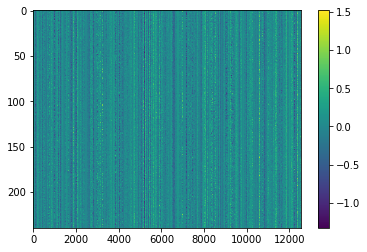

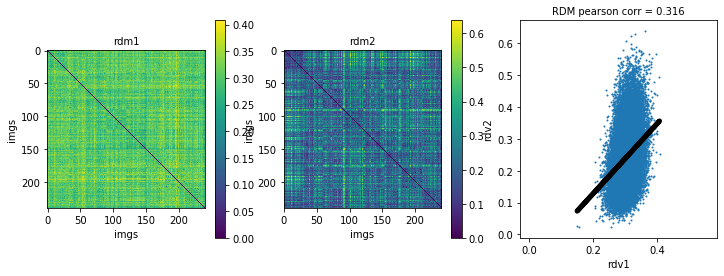

In [940]:
plt.figure()
rsa.plot_matrix(Y)
plt.figure(figsize=(12,4))
rsa.dm_corr_scatter([rsa.rdv(Y), rsa.rdv(Y_)])

## save each layer's activations

In [ ]:
n = len(layers_to_retain)  


absolute_paths = []
absolute_paths_np = []
all_layer_names = []

# iterate through layers, saving activation matrices as their own variables
for i in range(n):

    print("layer to save: %s" % layer_names_to_retain[i])
    print("    size in memory: %0.3f MB" % np.divide(float(sys.getsizeof(features[layers_to_retain[i]])),1000000))

    fn = os.path.join(savedir, layer_str_fmt[i] + '.mat')
    absolute_paths.append(fn)
    all_layer_names.append(layer_str_fmt[i].split('_')[1])

    # save activations using the Y variable name so things are smooth in matlab
    #sio.savemat(fn, {'Y': features[layer_names[i]]})

    fn2 = os.path.join(savedir, layer_str_fmt[i] + '.npy')
    absolute_paths_np.append(fn2)

    # save as numpy matrices too
    np.save(fn2, features[layer_names[i]])

    i+=1

# save info about layer names and the paths to the activation matrices
paths_fn = os.path.join(savedir, 'absolute_filepaths.mat')
names_fn = os.path.join(savedir, 'all_layer_names.mat')
sio.savemat(paths_fn, {'absoluteFilepaths': absolute_paths})
sio.savemat(names_fn, {'allLayerNames':     all_layer_names})

In [ ]:
absolute_act_filepaths = []

# not training mode
model.eval()

# no gradient saving 
with torch.no_grad():

    # dictionary comprehension
    features = {layer: None for layer in layers_to_retain}

    with tqdm(total=100,desc='Computing network activations') as pbar:

        # iterate through batches
        for batch_no, (imgs,labels) in enumerate(data_loader):
            
            batch_str = 'batch_' + str(batch_no)
            
            time.sleep(0.1)
            
            # nethook is saving features in a dictionary
            if torch.cuda.is_available():
                out = model(imgs.to(device))
            else:
                out = model(imgs)
            
            # counter for layer names
            idx = 0
            
            # accumulate activations by looping through layer names
            for layer_name in layers_to_retain:
                print(layer_name)
                # get name
                layer_str = layers_to_retain_fmt[idx]
                
                save_str = layer_str + '_' + batch_str + save_as
                save_fn = join(activation_savedir, save_str)
                
                absolute_act_filepaths.append(save_fn)
                
                # check if this layer has been saved before
                #if utils.check_dir_for_layer(activation_savedir, save_str, save_as) is True and overwrite is False:
                #    # do nothing
                #    print('doing nothing')
                #else:
                    
                # need to reshape for concatenation
                X = model.retained_layer(layer_name)
                #print(X.shape)

#                 if save_as == '.mat':
#                     if X.ndimension() == 4:
#                         X = X.permute(2,3,1,0)
#                     else:
#                         X = X.permute(1,0).unsqueeze(0).unsqueeze(0) # add singleton dimensions to agree with matlab pipeline

                # do something like this if you're expecting single batches to be many gigabytes
                #if sys.getsizeof(X.storage()) > max_batch_bytes:
                #    X = X.half() # halves numerical precision... probably not the best solution lol

                # move to CPU and detatch from computational grid
                X = X.cpu().detach().numpy() # we're going to convert to numpy now, 
                 #could do this later too if we wanted to keep things in torch
                #print("%d bytes" % (X.size * X.itemsize))

                # SAVE RIGHT HERE
                print("\tfile to save: %s" % save_str)
                print("\t\t\tsize in memory: %0.3f MB" % np.divide(float(X.size * X.itemsize),1000000))

                if save_as == '.npy':
                    np.save(save_fn, X)
                elif save_as == '.mat':
                    sio.savemat(save_fn, {'X': X})
                else:
                    raise ValueError('no file type specified')

                # concatenate if necessary
                if save_layer_rdvs is True:

                    # chunk on to the dictionary
                    if features[layer_name] is None:
                        features[layer_name] = X
                    else:                
                        features[layer_name] = np.concatenate((features[layer_name], X), axis = 0)

                idx += 1 

            pbar.update(100/len(data_loader))
